In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [3]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+design_region_height+monitor_position+monitor_blank+tpml, 1)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
# Ny = int(design_region_resolution * design_region_height) + 1
Ny = 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [4]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [5]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [6]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )

sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)


          axes (1,0,0), (0,1,0), (0,0,1)


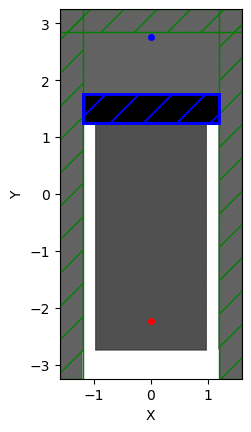

In [7]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.real(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
            simulation=sim,
            objective_functions=[J],
            objective_arguments=ob_list,
            design_regions=design_region,        # 한 개의 DesignRegion
            frequencies=[fcen],
            maximum_run_time=300,
        )

opt.plot2D(True)

In [8]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [14]:
eta_i = 0.5

def multi_mapping_ad(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        # sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = layer_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)



--- Iter 1 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.04689867368898295
Binary degree : 0.4121584040038059 


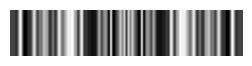


--- Iter 2 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.04876106688042071
Binary degree : 0.4126334877699778 


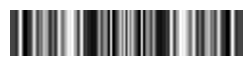


--- Iter 3 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.05259540606901707
Binary degree : 0.4137172555994253 


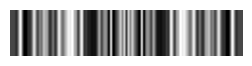


--- Iter 4 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.05856664797556857
Binary degree : 0.41525776987076035 


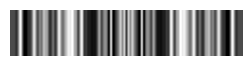


--- Iter 5 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.06676765225656961
Binary degree : 0.4171542506910718 


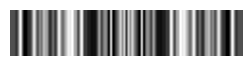


--- Iter 6 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.07714928052421842
Binary degree : 0.4196614219487875 


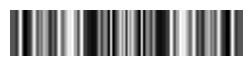


--- Iter 7 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.08942746419978594
Binary degree : 0.4218955591551136 


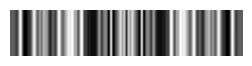


--- Iter 8 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.10232412872517882
Binary degree : 0.42321818831317537 


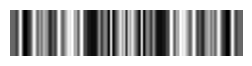


--- Iter 9 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.11355005156214462
Binary degree : 0.42424854353243174 


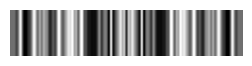


--- Iter 10 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.12205890432757051
Binary degree : 0.4247559527751979 


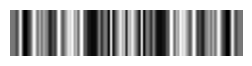


--- Iter 11 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.13126237709676802
Binary degree : 0.4262830402387755 


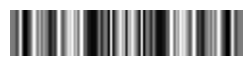


--- Iter 12 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.14416694540675698
Binary degree : 0.4293893212863509 


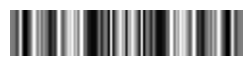


--- Iter 13 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.16225283465742468
Binary degree : 0.43393571567579065 


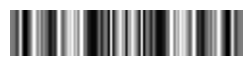


--- Iter 14 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.18156253666179337
Binary degree : 0.4382876393223692 


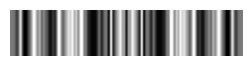


--- Iter 15 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.19518209388002944
Binary degree : 0.4435414129268692 


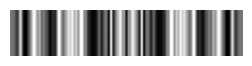


--- Iter 16 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.207401173226205
Binary degree : 0.45085819788574993 


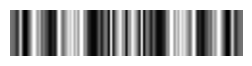


--- Iter 17 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.2189302598443137
Binary degree : 0.45794973272950057 


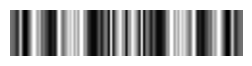


--- Iter 18 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.23325905181211176
Binary degree : 0.46569689637333356 


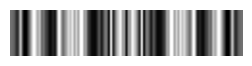


--- Iter 19 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.2532208013101268
Binary degree : 0.47360330522199745 


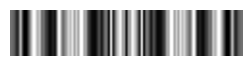


--- Iter 20 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.27503250042217486
Binary degree : 0.48005418414094725 


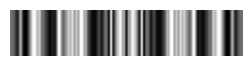


--- Iter 21 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.297022302222918
Binary degree : 0.489277879160183 


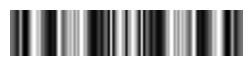


--- Iter 22 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.3220007734596169
Binary degree : 0.49902467767451136 


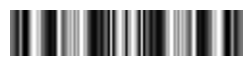


--- Iter 23 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.352288554758718
Binary degree : 0.5079148539489539 


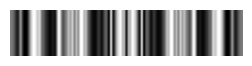


--- Iter 24 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.38990215696808744
Binary degree : 0.5168226512438334 


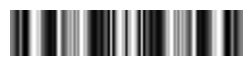


--- Iter 25 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.4293845981894586
Binary degree : 0.5277389897798941 


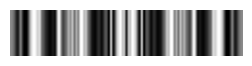


--- Iter 26 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.4528149395466542
Binary degree : 0.5389819670186665 


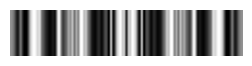


--- Iter 27 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.46520728754932744
Binary degree : 0.5499430253199924 


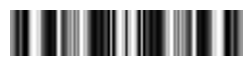


--- Iter 28 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.4555738630632926
Binary degree : 0.5570790537057255 


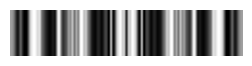


--- Iter 29 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5065358560386676
Binary degree : 0.5648716460891187 


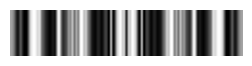


--- Iter 30 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5185650335758939
Binary degree : 0.5713353096682057 


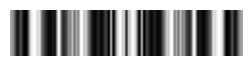


--- Iter 31 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5283913096549959
Binary degree : 0.5763515349183382 


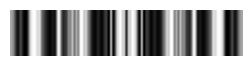


--- Iter 32 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5339518053190219
Binary degree : 0.5821374620780417 


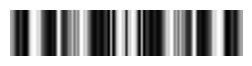


--- Iter 33 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5716571154185548
Binary degree : 0.5882756250327401 


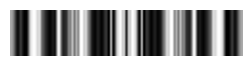


--- Iter 34 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5935956527807846
Binary degree : 0.5947643325190053 


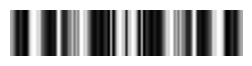


--- Iter 35 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6014589139929933
Binary degree : 0.6012506133963984 


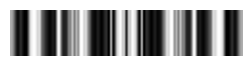


--- Iter 36 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6244590523486081
Binary degree : 0.6071233610156087 


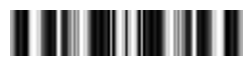


--- Iter 37 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6484133953926908
Binary degree : 0.612400420124052 


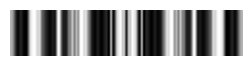


--- Iter 38 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6653626417119134
Binary degree : 0.6174905755622151 


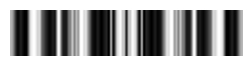


--- Iter 39 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6739420242014618
Binary degree : 0.6222933530750386 


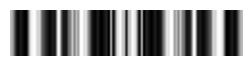


--- Iter 40 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7076919346341422
Binary degree : 0.6265888873960028 


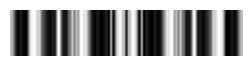


--- Iter 41 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7297944837295297
Binary degree : 0.6313033555759674 


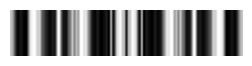


--- Iter 42 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7409373579336788
Binary degree : 0.6370916070784162 


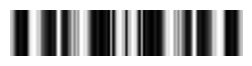


--- Iter 43 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7887148022063267
Binary degree : 0.6426766350581158 


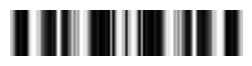


--- Iter 44 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8152360214366567
Binary degree : 0.6479793530632998 


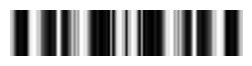


--- Iter 45 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8434944154403088
Binary degree : 0.6527343203501401 


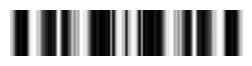


--- Iter 46 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8879104384336776
Binary degree : 0.6574101064584587 


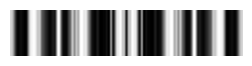


--- Iter 47 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8728553879790087
Binary degree : 0.660480056915685 


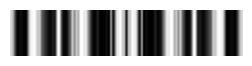


--- Iter 48 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.935281532451331
Binary degree : 0.6641410547461747 


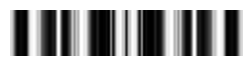


--- Iter 49 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9396319231007114
Binary degree : 0.6655777236119206 


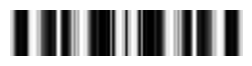


--- Iter 50 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.99352404472743
Binary degree : 0.6672956689462918 


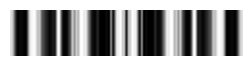


--- Iter 51 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0160130239654293
Binary degree : 0.6680452367066875 


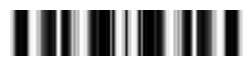


--- Iter 52 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9834676565178886
Binary degree : 0.6674116551343258 


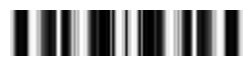


--- Iter 53 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0066867320256558
Binary degree : 0.6672138127898303 


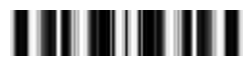


--- Iter 54 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.00733691032578
Binary degree : 0.6666838206108624 


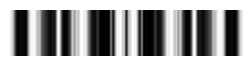


--- Iter 55 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0869083289474917
Binary degree : 0.6663305699855143 


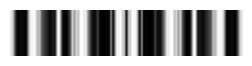


--- Iter 56 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0396779962207034
Binary degree : 0.6665654555584584 


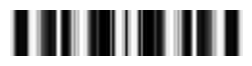


--- Iter 57 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.057544554458628
Binary degree : 0.6655630610711242 


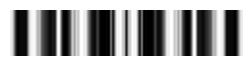


--- Iter 58 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1207883930928715
Binary degree : 0.665428061814625 


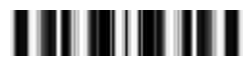


--- Iter 59 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0722429425633322
Binary degree : 0.6661871236147557 


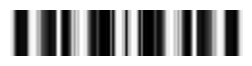


--- Iter 60 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1389935385415715
Binary degree : 0.6651724316639624 


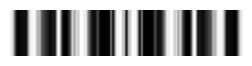


--- Iter 61 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.115940096603746
Binary degree : 0.6651500279861192 


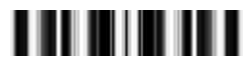


--- Iter 62 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.141379614396728
Binary degree : 0.6662592205095722 


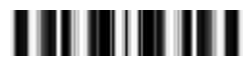


--- Iter 63 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1785327278824882
Binary degree : 0.666375585888958 


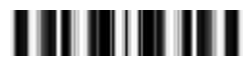


--- Iter 64 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.135552006840996
Binary degree : 0.666310917549069 


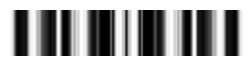


--- Iter 65 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1844113311534687
Binary degree : 0.6676635369238337 


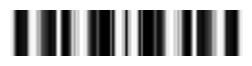


--- Iter 66 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1831737342157203
Binary degree : 0.6684926153178653 


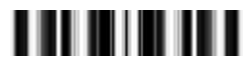


--- Iter 67 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.166593645182193
Binary degree : 0.6684983959468217 


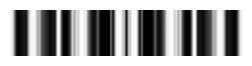


--- Iter 68 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2035892961732373
Binary degree : 0.6699712984758691 


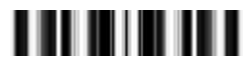


--- Iter 69 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1882951388363874
Binary degree : 0.6710831889184949 


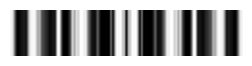


--- Iter 70 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1825972185996951
Binary degree : 0.6711229487962567 


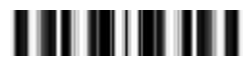


--- Iter 71 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2062667420422517
Binary degree : 0.6727008447617157 


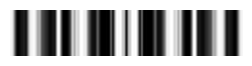


--- Iter 72 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.197087898302884
Binary degree : 0.6736236246935093 


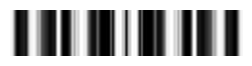


--- Iter 73 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.189144084471188
Binary degree : 0.6734967255259534 


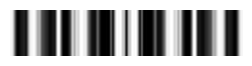


--- Iter 74 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1953245833010846
Binary degree : 0.6748515747750831 


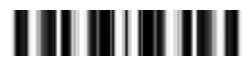


--- Iter 75 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2117745797127901
Binary degree : 0.6751726748044891 


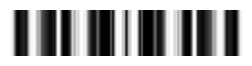


--- Iter 76 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2073628413286133
Binary degree : 0.6751576674980835 


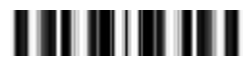


--- Iter 77 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1878891051327176
Binary degree : 0.6763651061052653 


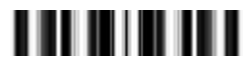


--- Iter 78 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2174924768813657
Binary degree : 0.6762401431639105 


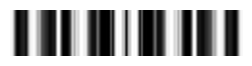


--- Iter 79 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2185813226396311
Binary degree : 0.6767832320992764 


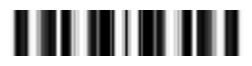


--- Iter 80 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.197744452212341
Binary degree : 0.6776445693554018 


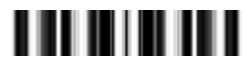


--- Iter 81 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2127637536031044
Binary degree : 0.6773432891064414 


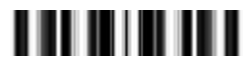


--- Iter 82 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2098566757576552
Binary degree : 0.6783496248394989 


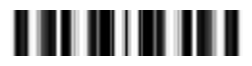


--- Iter 83 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2228181762485573
Binary degree : 0.6785516743191153 


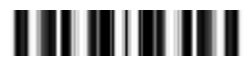


--- Iter 84 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.225299572828546
Binary degree : 0.6787305787795451 


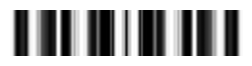


--- Iter 85 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.207600717208848
Binary degree : 0.6797187891813474 


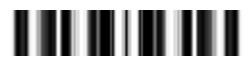


--- Iter 86 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.225756695427831
Binary degree : 0.6795675894092111 


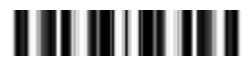


--- Iter 87 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2247238795192652
Binary degree : 0.6804976069769195 


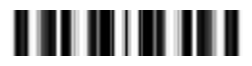


--- Iter 88 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.230491936274414
Binary degree : 0.6810421775823631 


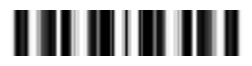


--- Iter 89 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.119991000809926
Current FOM: 1.2340315483743636
Binary degree : 0.6814235171483464 


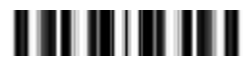


--- Iter 90 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0602713456081867
Binary degree : 0.6883257391873658 


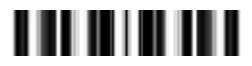


--- Iter 91 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0857189696133498
Binary degree : 0.6925950620119218 


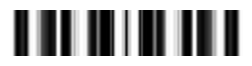


--- Iter 92 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.155438950651882
Binary degree : 0.692402216597729 


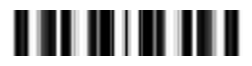


--- Iter 93 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0141872865726462
Binary degree : 0.6932292501096274 


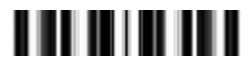


--- Iter 94 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.195648065069034
Binary degree : 0.6918841294265088 


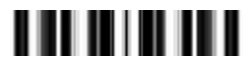


--- Iter 95 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.1055295522215116
Binary degree : 0.6904109882196544 


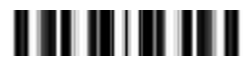


--- Iter 96 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.2419899993583159
Binary degree : 0.6905425883353613 


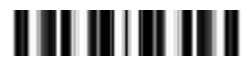


--- Iter 97 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.0673549990469333
Binary degree : 0.6908885073533817 


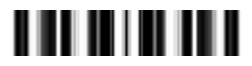


--- Iter 98 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.1268949485308992
Binary degree : 0.6892352980947885 


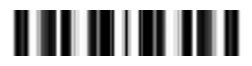


--- Iter 99 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.1947323182581977
Binary degree : 0.6881860258874978 


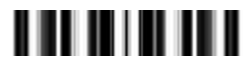


--- Iter 100 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.1737406948615523
Binary degree : 0.6875792872901061 


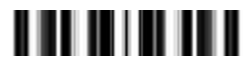


--- Iter 101 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.2284713500188071
Binary degree : 0.6858314400932167 


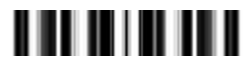


--- Iter 102 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.1984695474292997
Binary degree : 0.6845595330320808 


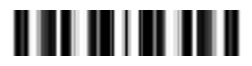


--- Iter 103 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.249578944845655
Current FOM: 1.236150154588187
Binary degree : 0.6844891871716696 


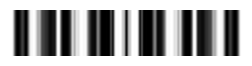


--- Iter 104 ---
Starting forward run...


In [ ]:
# n = Nx*layer_num
# x = np.ones(n) * 0.5

n = Nx * layer_num
np.random.seed(3)           # (선택) 재현 가능한 결과를 원할 때 시드 고정
x = np.random.rand(n)  

cur_beta = 2

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx*Ny
    rho_list = [rho_full[i*size_each:(i+1)*size_each]
                for i in range(layer_num)]

    f0, dJ_du = opt(rho_list,
                    need_value=True,
                    need_gradient=True,
                    beta=beta)
    
    if not isinstance(dJ_du, (list, tuple)):
        dJ_du = [dJ_du]

    dJ_flat = np.concatenate([np.array(d).flatten() for d in dJ_du])

    gradient_full = tensor_jacobian_product(multi_mapping_ad, 0)(
        v, eta_i, beta, dJ_flat
    )

    grad_list = [gradient_full[i*size_each:(i+1)*size_each]
                 for i in range(layer_num)]
    
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)

    v_new = np.concatenate(v_new_layers)

    f_val = float(np.real(f0))

    beta_new = beta  # 기본값은 그대로
    if len(evaluation_history) >= 3:
        # 최근 3개 값: [n-3] [n-2] [n-1] (0-based indexing)
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        # 변화율 계산
        change1 = abs(f_curr  - f_prev1) / (abs(f_prev1) + 1e-12)
        change2 = abs(f_prev1 - f_prev2) / (abs(f_prev2) + 1e-12)

        # 둘 다 0.5% 미만이면 β를 1.2배로
        if change1 < 0.005 and change2 < 0.005:
            beta_new = beta + 8*np.tanh((beta - 0.5)*0.01)

    evaluation_history.append(f_val)
    beta_history.append(beta_new)
    cur_iter[0] += 1

    print("Current beta: {}".format(beta_new))
    print("Current FOM: {}".format(f0))
    print("Binary degree : {} ".format(bin_deg))

    plt.figure(figsize=(3,2))
    ax = plt.gca()
    opt.plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width,region_height_each*layer_num-1/resolution,0),
            center=mp.Vector3(0, full_center_y,0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    return v_new, beta_new

mp.verbosity(0)
Max_iter = 300
# Main loop (변경 없음)
while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.98:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        break

In [296]:
# 1) 배열로 변환
eval_hist = np.array(evaluation_history)

# 2) 최대값과 그 인덱스 찾기 (0-based)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()

# 3) 사람이 셀 때 보통 1부터 시작하니 +1
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

최대 FoM = 0.025534 는 iteration 148 에서 나왔습니다.


/tmp/ipykernel_127755/3688139528.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend( fontsize = 14)


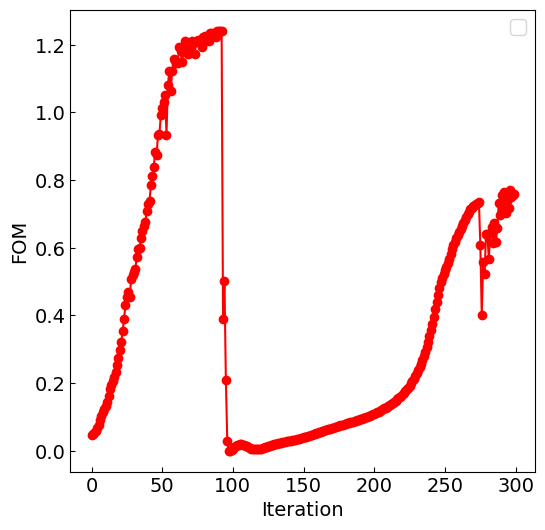

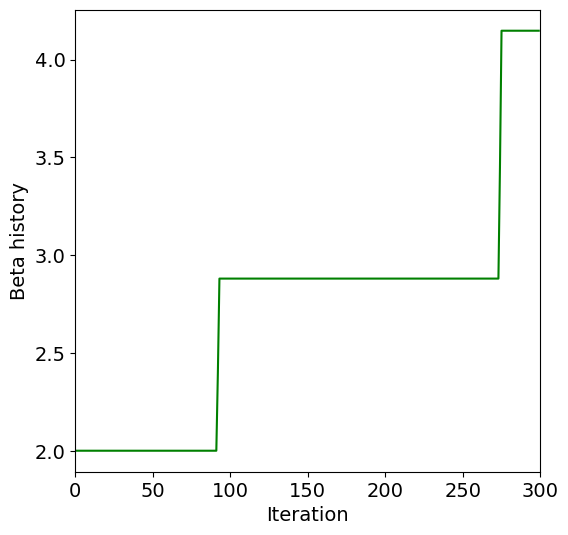

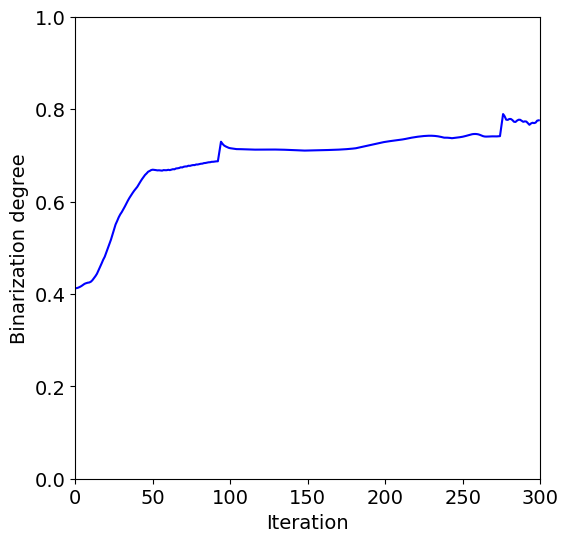

: 

: 

In [ ]:
################ FOM plot ################ 
plt.figure(figsize = (6,6))
plt.plot(evaluation_history, 'or-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tick_params(direction = 'in')
plt.legend( fontsize = 14)
plt.show()

################ beta history plot ################ 
plt.figure(figsize = (6,6))
plt.plot(beta_history, 'g-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Beta history',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(0, np.array(cur_iter))
plt.show()

################ Binarization degree plot ################ 
plt.figure(figsize = (6,6))
plt.plot(binarization_history, 'b-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Binarization degree',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(0, np.array(cur_iter))
plt.ylim(0,1)
plt.show()

/tmp/ipykernel_959/3688139528.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend( fontsize = 14)


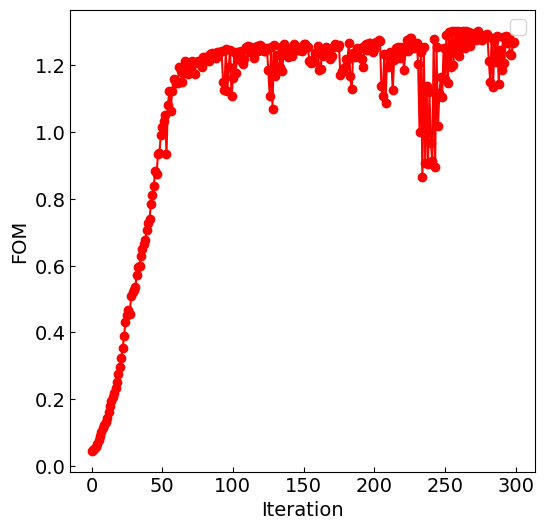

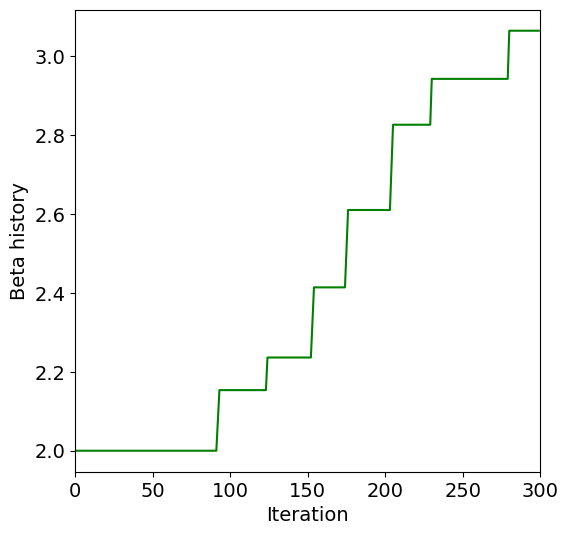

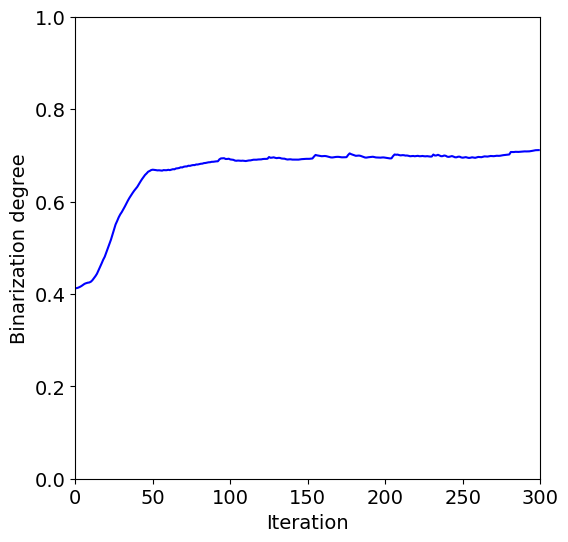

: 

In [ ]:
################ FOM plot ################ 
plt.figure(figsize = (6,6))
plt.plot(evaluation_history, 'or-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tick_params(direction = 'in')
plt.legend( fontsize = 14)
plt.show()

################ beta history plot ################ 
plt.figure(figsize = (6,6))
plt.plot(beta_history, 'g-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Beta history',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(0, np.array(cur_iter))
plt.show()

################ Binarization degree plot ################ 
plt.figure(figsize = (6,6))
plt.plot(binarization_history, 'b-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Binarization degree',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(0, np.array(cur_iter))
plt.ylim(0,1)
plt.show()

In [147]:
# multi2 = design_variables[0].weights
# multi1 = design_variables[1].weights
# k = design_variables.weights
# opt.update_design([k])
opt.update_design([multi2, multi1])

(-1.2, 1.2, 1.01, 1.99)

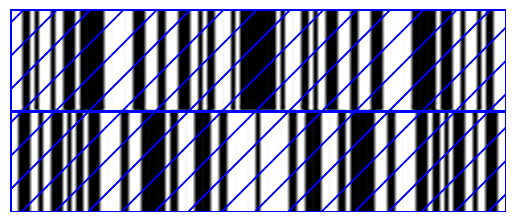

In [149]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = mp.Vector3(design_region_width, design_region_height-1/resolution, 0), center = mp.Vector3(0, full_center_y,0)),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

(-1.2, 1.2, 1.26, 1.74)

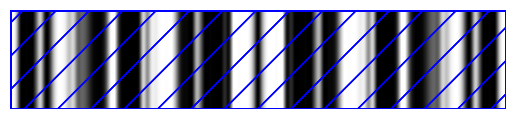

In [62]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = mp.Vector3(design_region_width, design_region_height-1/resolution, 0), center = mp.Vector3(0, full_center_y,0)),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

<Axes: xlabel='X', ylabel='Y'>

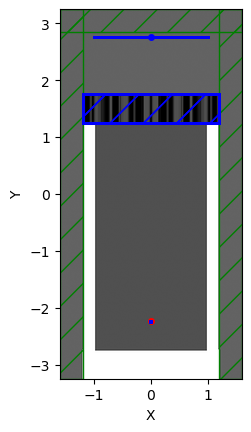

In [63]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


-----------
Initializing structure...
time for choose_chunkdivision = 0.000139952 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.5 x 0 with resolution 50
     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0543852 s
time for set_conductivity = 0.00190496 s
time for set_conduc

/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


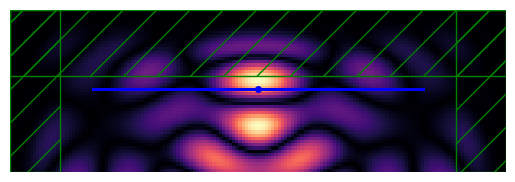

In [ ]:
mp.verbosity(1)
sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-5))
# sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-3))

opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


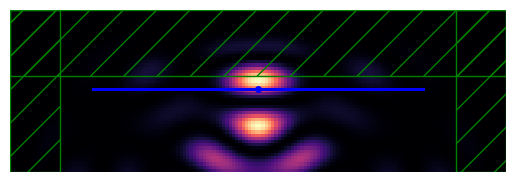

In [72]:
opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

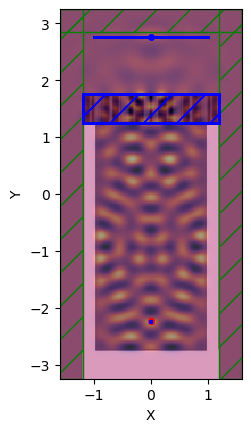

In [65]:
opt.sim.plot2D(fields = mp.Ez,
           field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 0.5,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

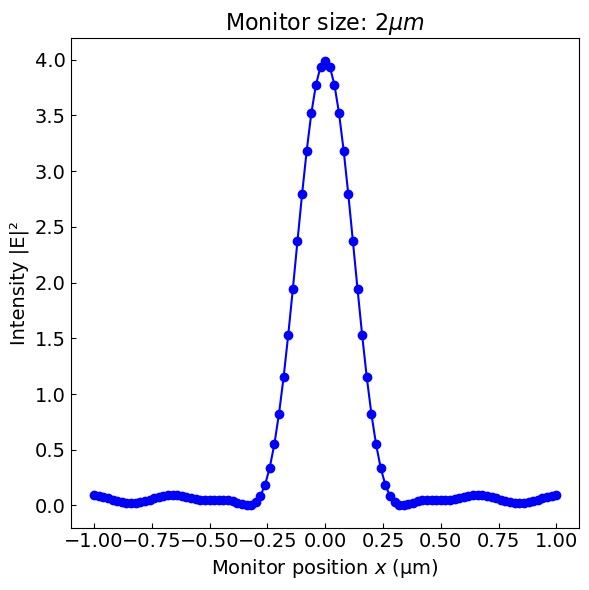

In [66]:
external_field_array = np.abs(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [67]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100

print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 1.4862238406363701
Output flux : 1.0633035492352916
EQE(%) : 71.54397071036131 %


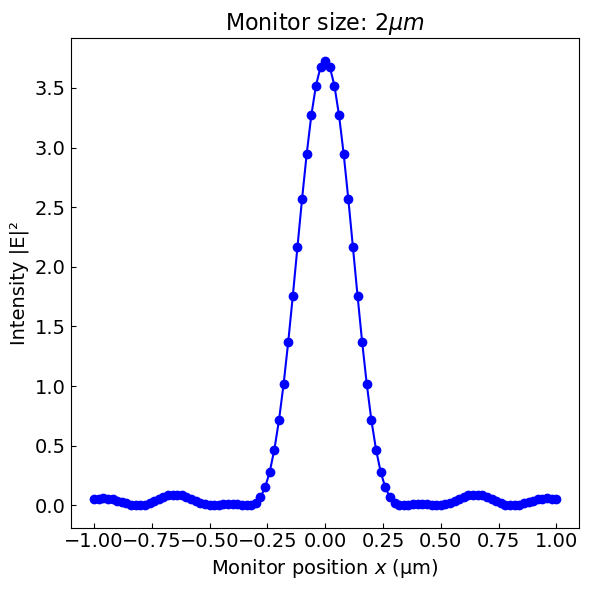

In [68]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

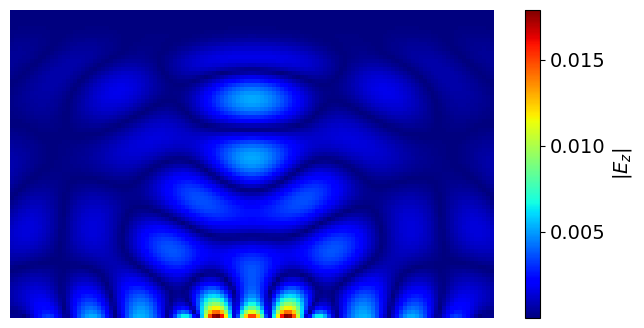

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt.sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

In [70]:
import numpy as np

I = np.real(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.array(mp.get_fluxes(input_flux))[0]
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

Input flux : 1.4862238406363701
Output flux : 1.0633035492352916
±0.340 µm 구간 integrated intensity: 1.0340009504704253
1차 ring까지의 Optical EQE : 69.57235661269486 %


In [71]:
import numpy as np

# 1) 강도 계산
I = np.abs(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
center_idx = np.argmax(I)

# 2) 첫 번째 링 경계: 미분으로 valley 찾기
dI = np.diff(I)
valleys = np.where((dI[:-1] < 0) & (dI[1:] > 0))[0] + 1
valleys = valleys[valleys > center_idx]
if valleys.size == 0:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")
idx_valley = valleys[0]
x_limit = abs(x[idx_valley])

# 3) 적분 구간 설정
mask = (x >= -x_limit) & (x <= x_limit)
dx = x[1] - x[0]
flux_slice = np.sum(I[mask]) * dx

# 4) Flux 모니터 값
input_flux  = np.array(mp.get_fluxes(input_flux))[0]
output_flux = np.array(mp.get_fluxes(out_flux))[0]

# 5) Optical EQE 계산: 출력 flux 비율을 사용
optical_eqe = output_flux / input_flux * 100

print(f"±{x_limit:.3f} µm 구간 intensity 적분: {flux_slice:.4f}")
print(f"모니터 기반 Optical EQE: {optical_eqe:.2f}%")


±0.340 µm 구간 intensity 적분: 1.0340
모니터 기반 Optical EQE: 71.54%


In [287]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'